### **Introduction**

> Automatic voice-pathology detection and classification systems may help clinicians to detect the exis
tence of any voice pathologies and the type of pathology from which patients suffer in the early stages
Voice pathologies affect the vocal folds, producing irregular vibrations due to the malfunctioning of many factors contributing to vocal vibrations. In addition, voice pathologies affect vocal-fold vibration differently depending on the type of disorder and the location of the disease in the vocal folds, making them produce different basic tones. \\
In this project we've used CNN as a deep learning algorithm , in order to train our model on the dataset that contains healthy and pathological voices , after applying some filters such as FFT on the voices's signals to avoid noisy data. 

### **Download the dataset**

In [ ]:
!unzip /content/pathological.zip

### **Import Libraries**

In [ ]:
import librosa
import glob 
import numpy as np
from keras.layers import Dense, Input, Flatten, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from statistics import mean, median

from scipy.io import wavfile
from scipy.fftpack import dct

### **Visualization of audios' frequencies**

In [ ]:
### Healthy audio's frequencies visualization
sample_rate, signal = wavfile.read('/content/pathological/Normal/1-a_h.wav')

signal = signal[0:int(10* sample_rate)]
Time = np.linspace(0, len(signal) / sample_rate, num=len(signal))

plt.plot(Time, signal)

In [ ]:
### Pathological audio's frequencies visualization
sample_rate, signal = wavfile.read('/content/pathological/pathology/1-a_h-egg.wav')

signal = signal[0:int(10* sample_rate)]
Time = np.linspace(0, len(signal) / sample_rate, num=len(signal))

plt.plot(Time, signal)

### **Pre-Emphasis**

> The first step is to apply a pre-emphesis filter on signal to amplify the high frequencies. A pre-emphesis filter is useful in several ways:
 - balance frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies 
 - avoid numerical problems during fourier operatio
 - Might also improve the signal to Noise Ratio (SNR)

> The pre-emphesis filter can be applied to a signal x using the first order filter in the following equation: y(t)=x(t)−αx(t−1), which can be easily implemented using the following line, where typical values for the filter coefficeint ( α ) are 0.95 to 0.97, pre_empasis = 0.97

In [ ]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

> After pre-emphasis, we need to split the signal into short-time frames. The rationale behind this step is that frequencies in a signal change over time, so in most cases it dosen't make sense to do the Fourier Transform across the entier signal in that we would lose the frequency contours of the signal over time. To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time. Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.




In [ ]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [ ]:
frames *= np.hamming(frame_length)
# frames *= 0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length - 1))  # Explicit Implementation **


### **Fourier-Transfrom**

> We can now do an N-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time-Fourier-Transfrom (STFT), where N is typically 256 or 512, NFFT = 512; and then compute the power spectrum (Periodogram) using the following equation: 

$$ P = \frac{ \vert FFT(x_{i})\vert }{2N}$$

where , xi is the ith frame of signal x. This can be easily imlemented with the following lines:

In [ ]:
NFFT = 512

mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [ ]:
nfilt = 40

low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

After applying the filter bank to the power spectrum (peridogram) of the signal, we obtain the following spectrogram:

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(
    np.transpose(filter_banks),
    interpolation="nearest",
    aspect="auto",
    cmap=plt.cm.afmhot_r,
    origin="lower",
)
fig.colorbar(cax)
plt.title("Mel compression Spectrogram")
plt.show()

> It turns out that filter bank coefficients computed in the previous step are higly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform(DCT) to decorrelate the filter bank coefficients and yield compressed representation of filter banks.

In [ ]:
num_ceps = 12
mfcc = dct(filter_banks, type = 2, axis=1, norm="ortho")[:,1: (num_ceps + 1)] # keep 2-13

> One may apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs which has been claimed to improve speech recognition in noisy signals

In [ ]:


cep_lifter = 22
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n/ cep_lifter)
mfcc *= lift

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(
    np.transpose(mfcc),
    interpolation="nearest",
    aspect="auto",
    cmap=plt.cm.afmhot_r,
    origin="lower",
)
fig.colorbar(cax)
plt.title("MFCC Spectrogram")
plt.show()

### **Build CNN model**

In [ ]:
pathological_dir = "/content/pathological/pathology/"
pathological_paths = glob.glob(pathological_dir+ "*.wav")

healthy_dir = "/content/pathological/Normal/"
healthy_paths = glob.glob(healthy_dir+"*.wav")

X = []
y = []

for pathological in pathological_paths:
    X.append(librosa.load(pathological))
    y.append(1)
    
for healthy in healthy_paths:
    X.append(librosa.load(healthy))
    y.append(0)

In [ ]:
def MFCC(y, sr, n_mfcc=13):
    return np.mean(librosa.feature.mfcc(y=y, n_mfcc=n_mfcc, sr=sr), axis=1)

MFCC_data = []

for signal in X:
    MFCC_data.append(MFCC(signal[0], signal[1]))

X_MFCC = np.array(MFCC_data)

In [ ]:
'''X_train, X_test, y_train, y_test = train_test_split(X_MFCC, y, test_size=0.2, random_state=42)
x_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

batch_size=10
epochs=10'''

In [ ]:
#input_shape = (X_MFCC.shape[1], X_MFCC.shape[2], 1)

model = Sequential([               
    Dense(124, activation='relu'), 
    Dense(16, activation='relu'),
    Dense(4, activation='relu'),  
    
    Dense(1, activation='sigmoid') 
    ])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

X_train, X_test, y_train, y_test = train_test_split(X_MFCC, np.array(y), test_size=0.3, random_state=42)
x_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

batch_size=16
epochs=10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid))

print(model.summary())

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

y_pred = model.predict(X_test)
y_pred = np.where(y_pred < 0.5, 0, 1)
print(classification_report(y_test, y_pred))

matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(10,10))  
sn.heatmap(matrix, annot = True, annot_kws={"size": 10}, fmt = '.1f')

> To further test the robustness of the proposed methodology, the accuracy, recall, precision score and F1 score for the proposed weighted classifier were calculated (in the figure below)

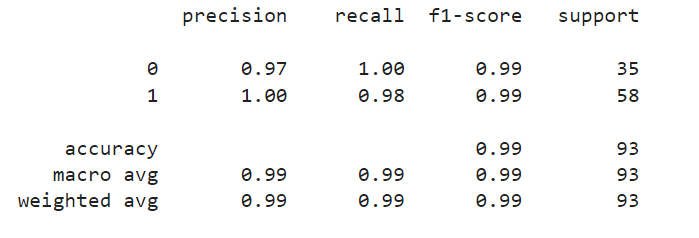



> One additional way of representing the results of the model is to build a confusion matrix. The Y-axis of the confusion matrix holds the predicted values, while the X-axis holds the true values. The confusion matrix for our latest experiment is illustrated in the below Figure help of the confusion matrix, the number of true positives, true negatives, false positives, and false negatives could be calculated, which further helped in checking the efficacy of the model. 
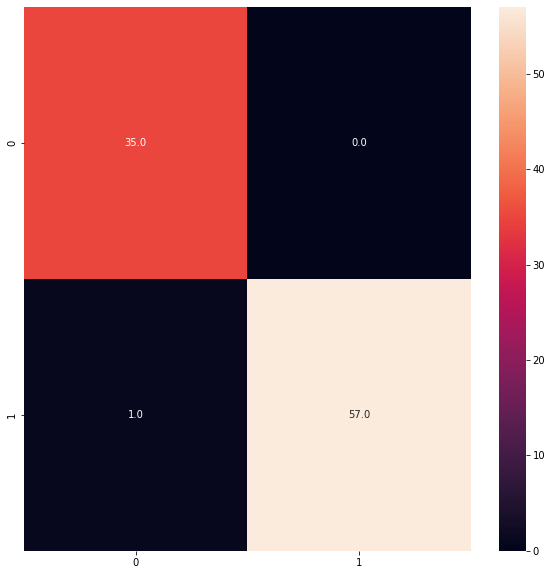

>This matrix shows that among the total of 67 pathological audios, only 10 audios were misclassified and 0 audios from true healthy audios, which are 57 , were predicted as pathological.

> The below Figure shows the training and validation accuracy as well as the training and validation loss  obtained during the training of CNN model for 10 epochs. The training accuracy and validation accuracy all exceeded 99%, also the training loss and validation loss were below 0.5, which means that the CNN model has the potential power to acquire excellent performance.

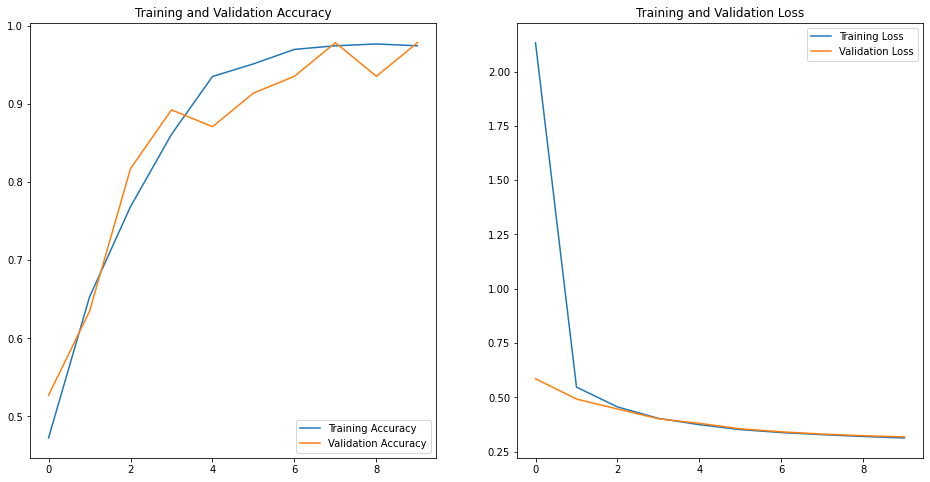